# Idea
Do some Plotting of singular features

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
from py_dataset import get_all_files_df
from py_dataset import read_in_files

In [3]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [4]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
feature_family
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


file_path filetype  filesize_bytes  \
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419   

  researcher_name device_name experiment feature_family  \
0          Heqing     device1   1_normal     block_data   

               file_name          device  
0  e4_5f_01_68_35_e6.csv  Heqing_device1

#### Get Single data
* device = Heqing_device2 => most data
* go through all features of each feature_family
    * for one 
        1. First: Sum up over all experiments/Malwares/labels first
        2. Then: Then only specific attack in comparison?
            * each column: normalize the data
            * plot boxplot: distribution

In [5]:
single_dev = df[df["device"] == "Heqing_device2"]
assert len(single_dev["device"].unique()) == 1

In [6]:
single_dev_single_data_source = single_dev[single_dev["feature_family"] == "KERN_data"]
assert len(single_dev_single_data_source["feature_family"].unique()) == 1
single_dev_single_data_source.shape

(19, 9)

In [7]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)

In [8]:
print("len:", len(vectors))
vectors.columns

len: 10344


Index(['seconds', 'connectivity', 'alarmtimer:alarmtimer_fired',
       'alarmtimer:alarmtimer_start', 'block:block_bio_backmerge',
       'block:block_bio_remap', 'block:block_dirty_buffer',
       'block:block_getrq', 'block:block_touch_buffer', 'block:block_unplug',
       'cachefiles:cachefiles_create', 'cachefiles:cachefiles_lookup',
       'cachefiles:cachefiles_mark_active', 'clk:clk_set_rate',
       'cpu-migrations', 'cs', 'dma_fence:dma_fence_init',
       'fib:fib_table_lookup', 'filemap:mm_filemap_add_to_page_cache',
       'gpio:gpio_value', 'ipi:ipi_raise', 'irq:irq_handler_entry',
       'irq:softirq_entry', 'jbd2:jbd2_handle_start', 'jbd2:jbd2_start_commit',
       'kmem:kfree', 'kmem:kmalloc', 'kmem:kmem_cache_alloc',
       'kmem:kmem_cache_free', 'kmem:mm_page_alloc',
       'kmem:mm_page_alloc_zone_locked', 'kmem:mm_page_free',
       'kmem:mm_page_pcpu_drain', 'mmc:mmc_request_start', 'net:net_dev_queue',
       'net:net_dev_xmit', 'net:netif_rx', 'page-faults',
  

In [24]:
vectors.reset_index(inplace=True, drop=True)  # drop: "timestamp"
cols_to_exclude_from_scaling = ["experiment"]
exclude_from_scaling = vectors[cols_to_exclude_from_scaling]
vectors_scaled = vectors.drop(columns=cols_to_exclude_from_scaling, inplace=False)

In [25]:
def remove_outliers_iqr_all_columns(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [26]:
from sklearn.preprocessing import minmax_scale, robust_scale, scale

# vectors_scaled = pd.DataFrame(
#     robust_scale(vectors_scaled, axis=0, quantile_range=(40.0, 60.0), with_centering=False, with_scaling=False),
#     columns=vectors_scaled.columns)
# vectors_scaled = remove_outliers_iqr_all_columns(vectors_scaled)

# vectors_scaled = pd.DataFrame(scale(vectors_scaled, axis=0),
#                               columns=vectors_scaled.columns)

vectors_robust_scaled = vectors_scaled.copy()
vectors_robust_scaled = remove_outliers_iqr_all_columns(vectors_robust_scaled)
vectors_robust_scaled = pd.DataFrame(minmax_scale(vectors_robust_scaled, axis=0), columns=vectors_robust_scaled.columns)
vectors_robust_scaled = pd.concat([vectors_robust_scaled, exclude_from_scaling], axis=1)

vectors_scaled = pd.DataFrame(minmax_scale(vectors_scaled, axis=0), columns=vectors_scaled.columns)
vectors_scaled = pd.concat([vectors_scaled, exclude_from_scaling], axis=1)

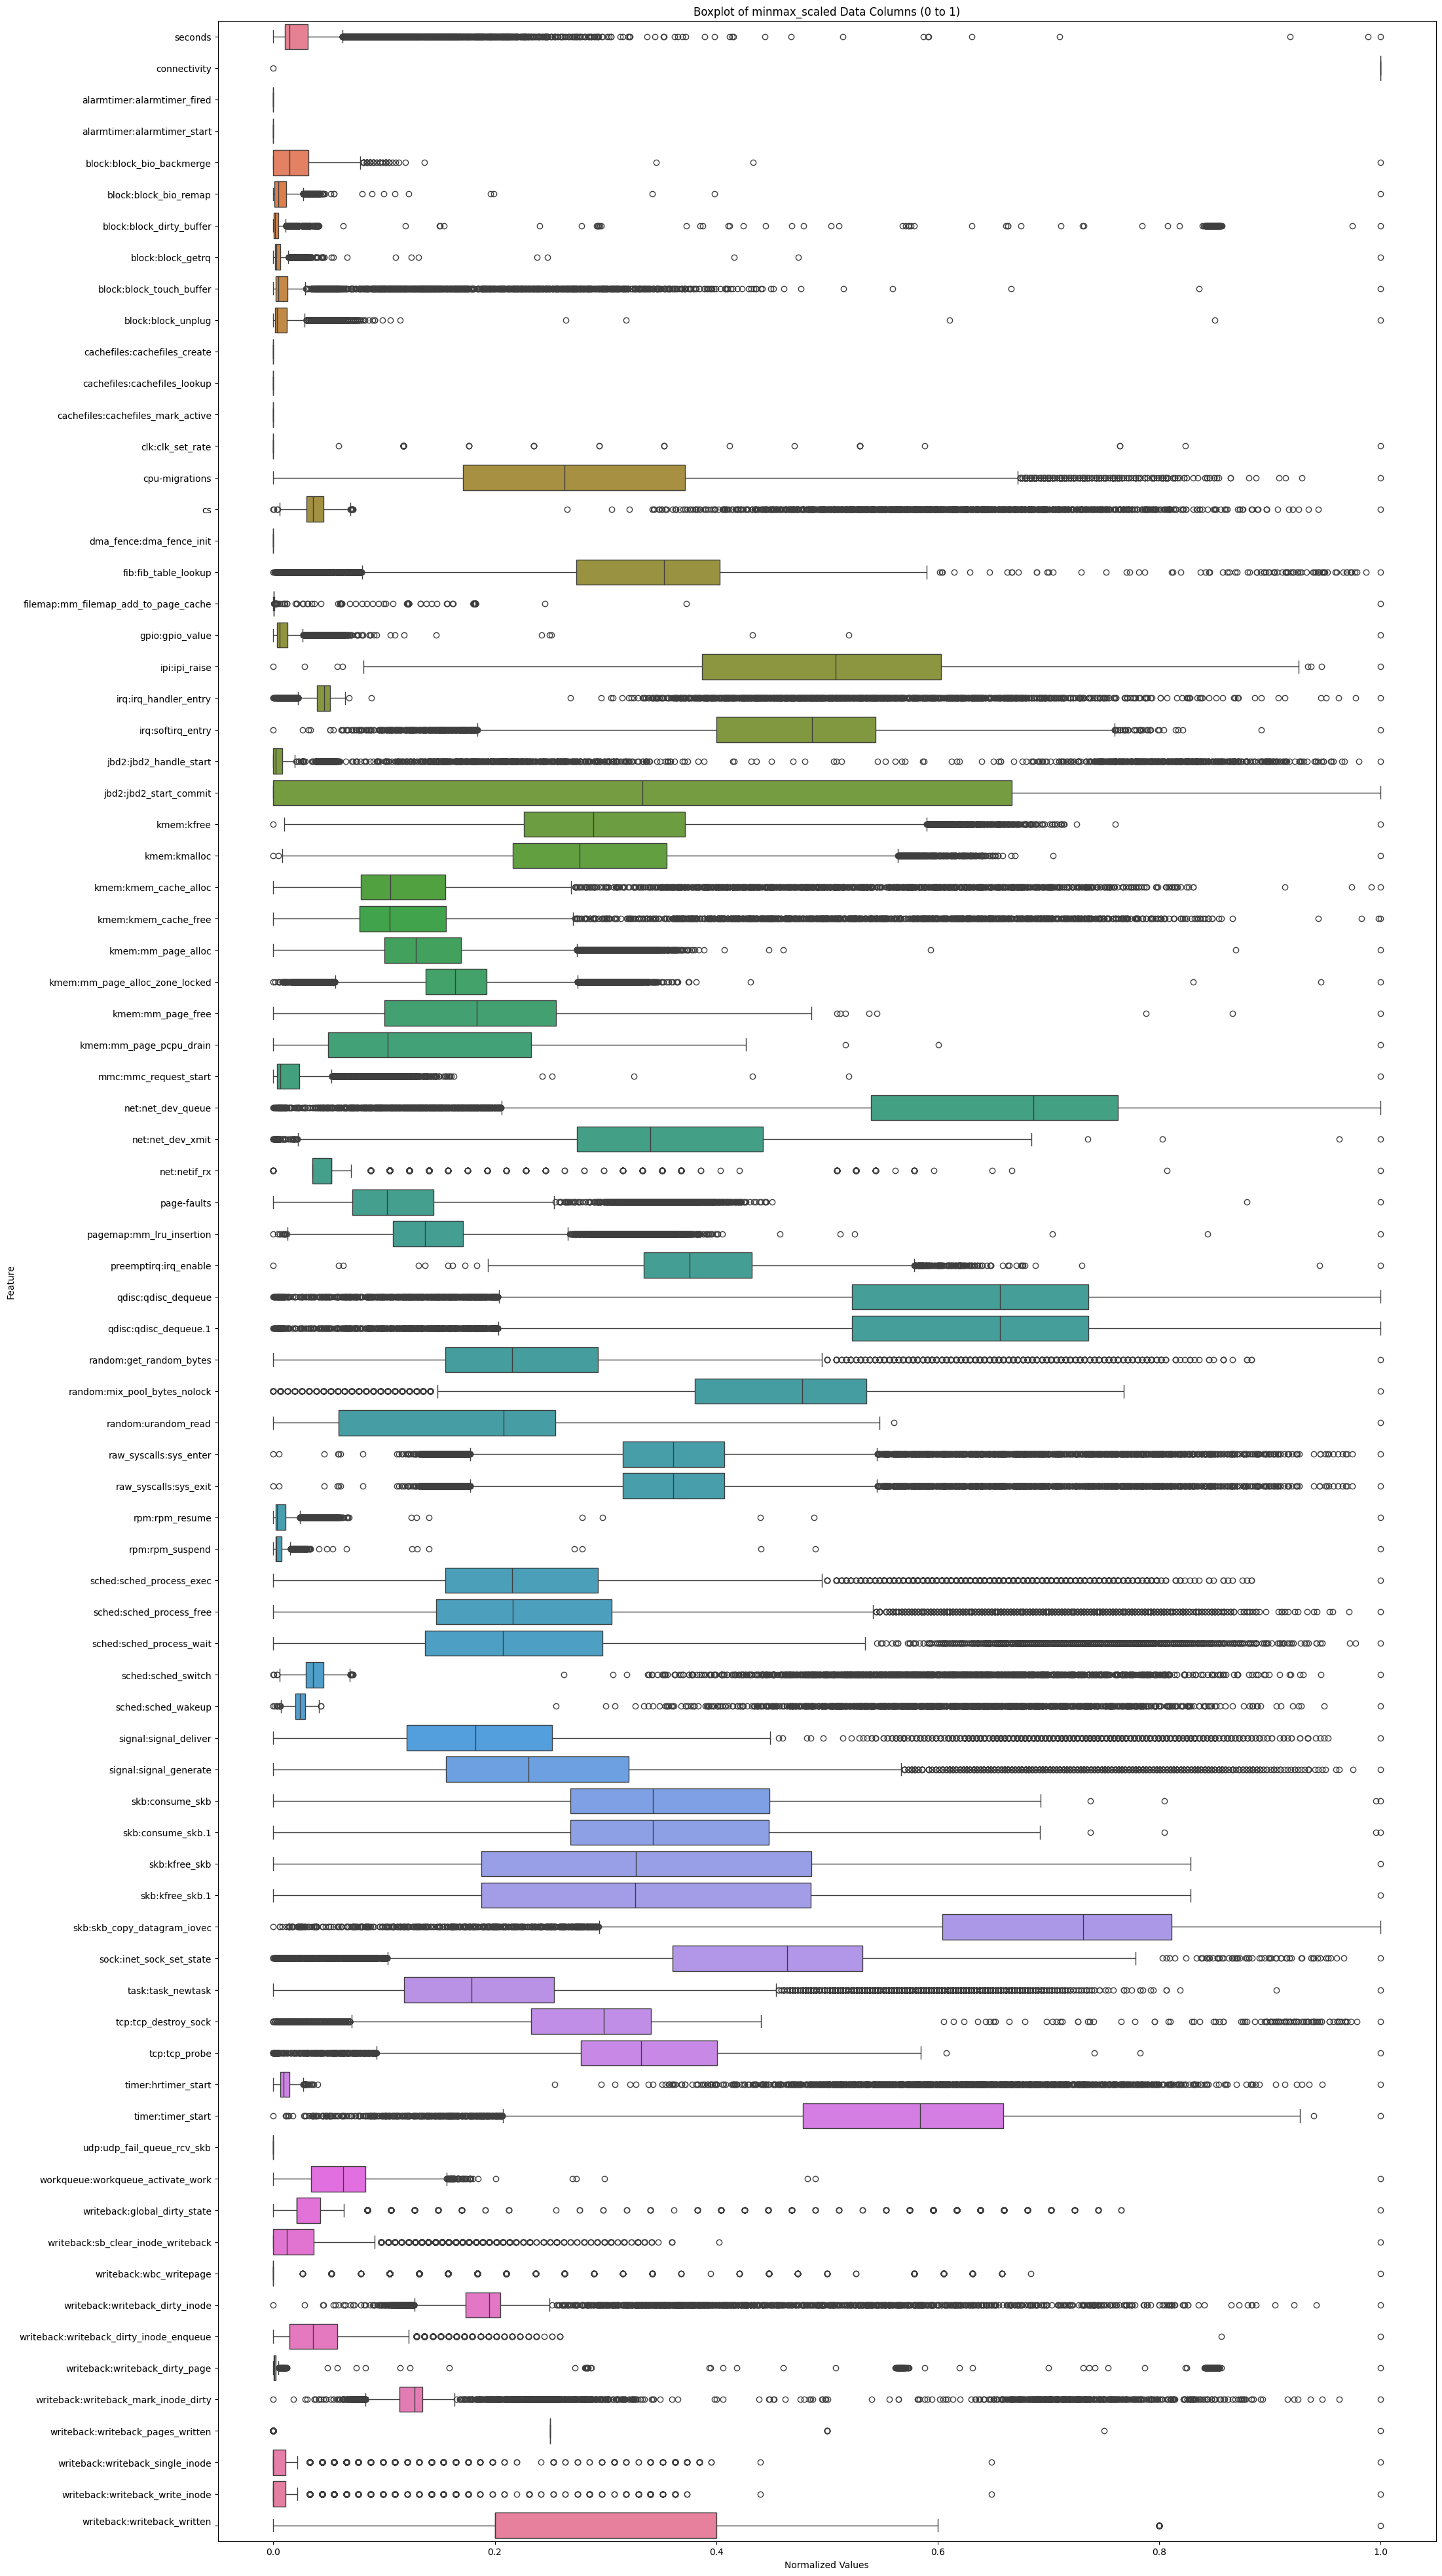

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 50))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

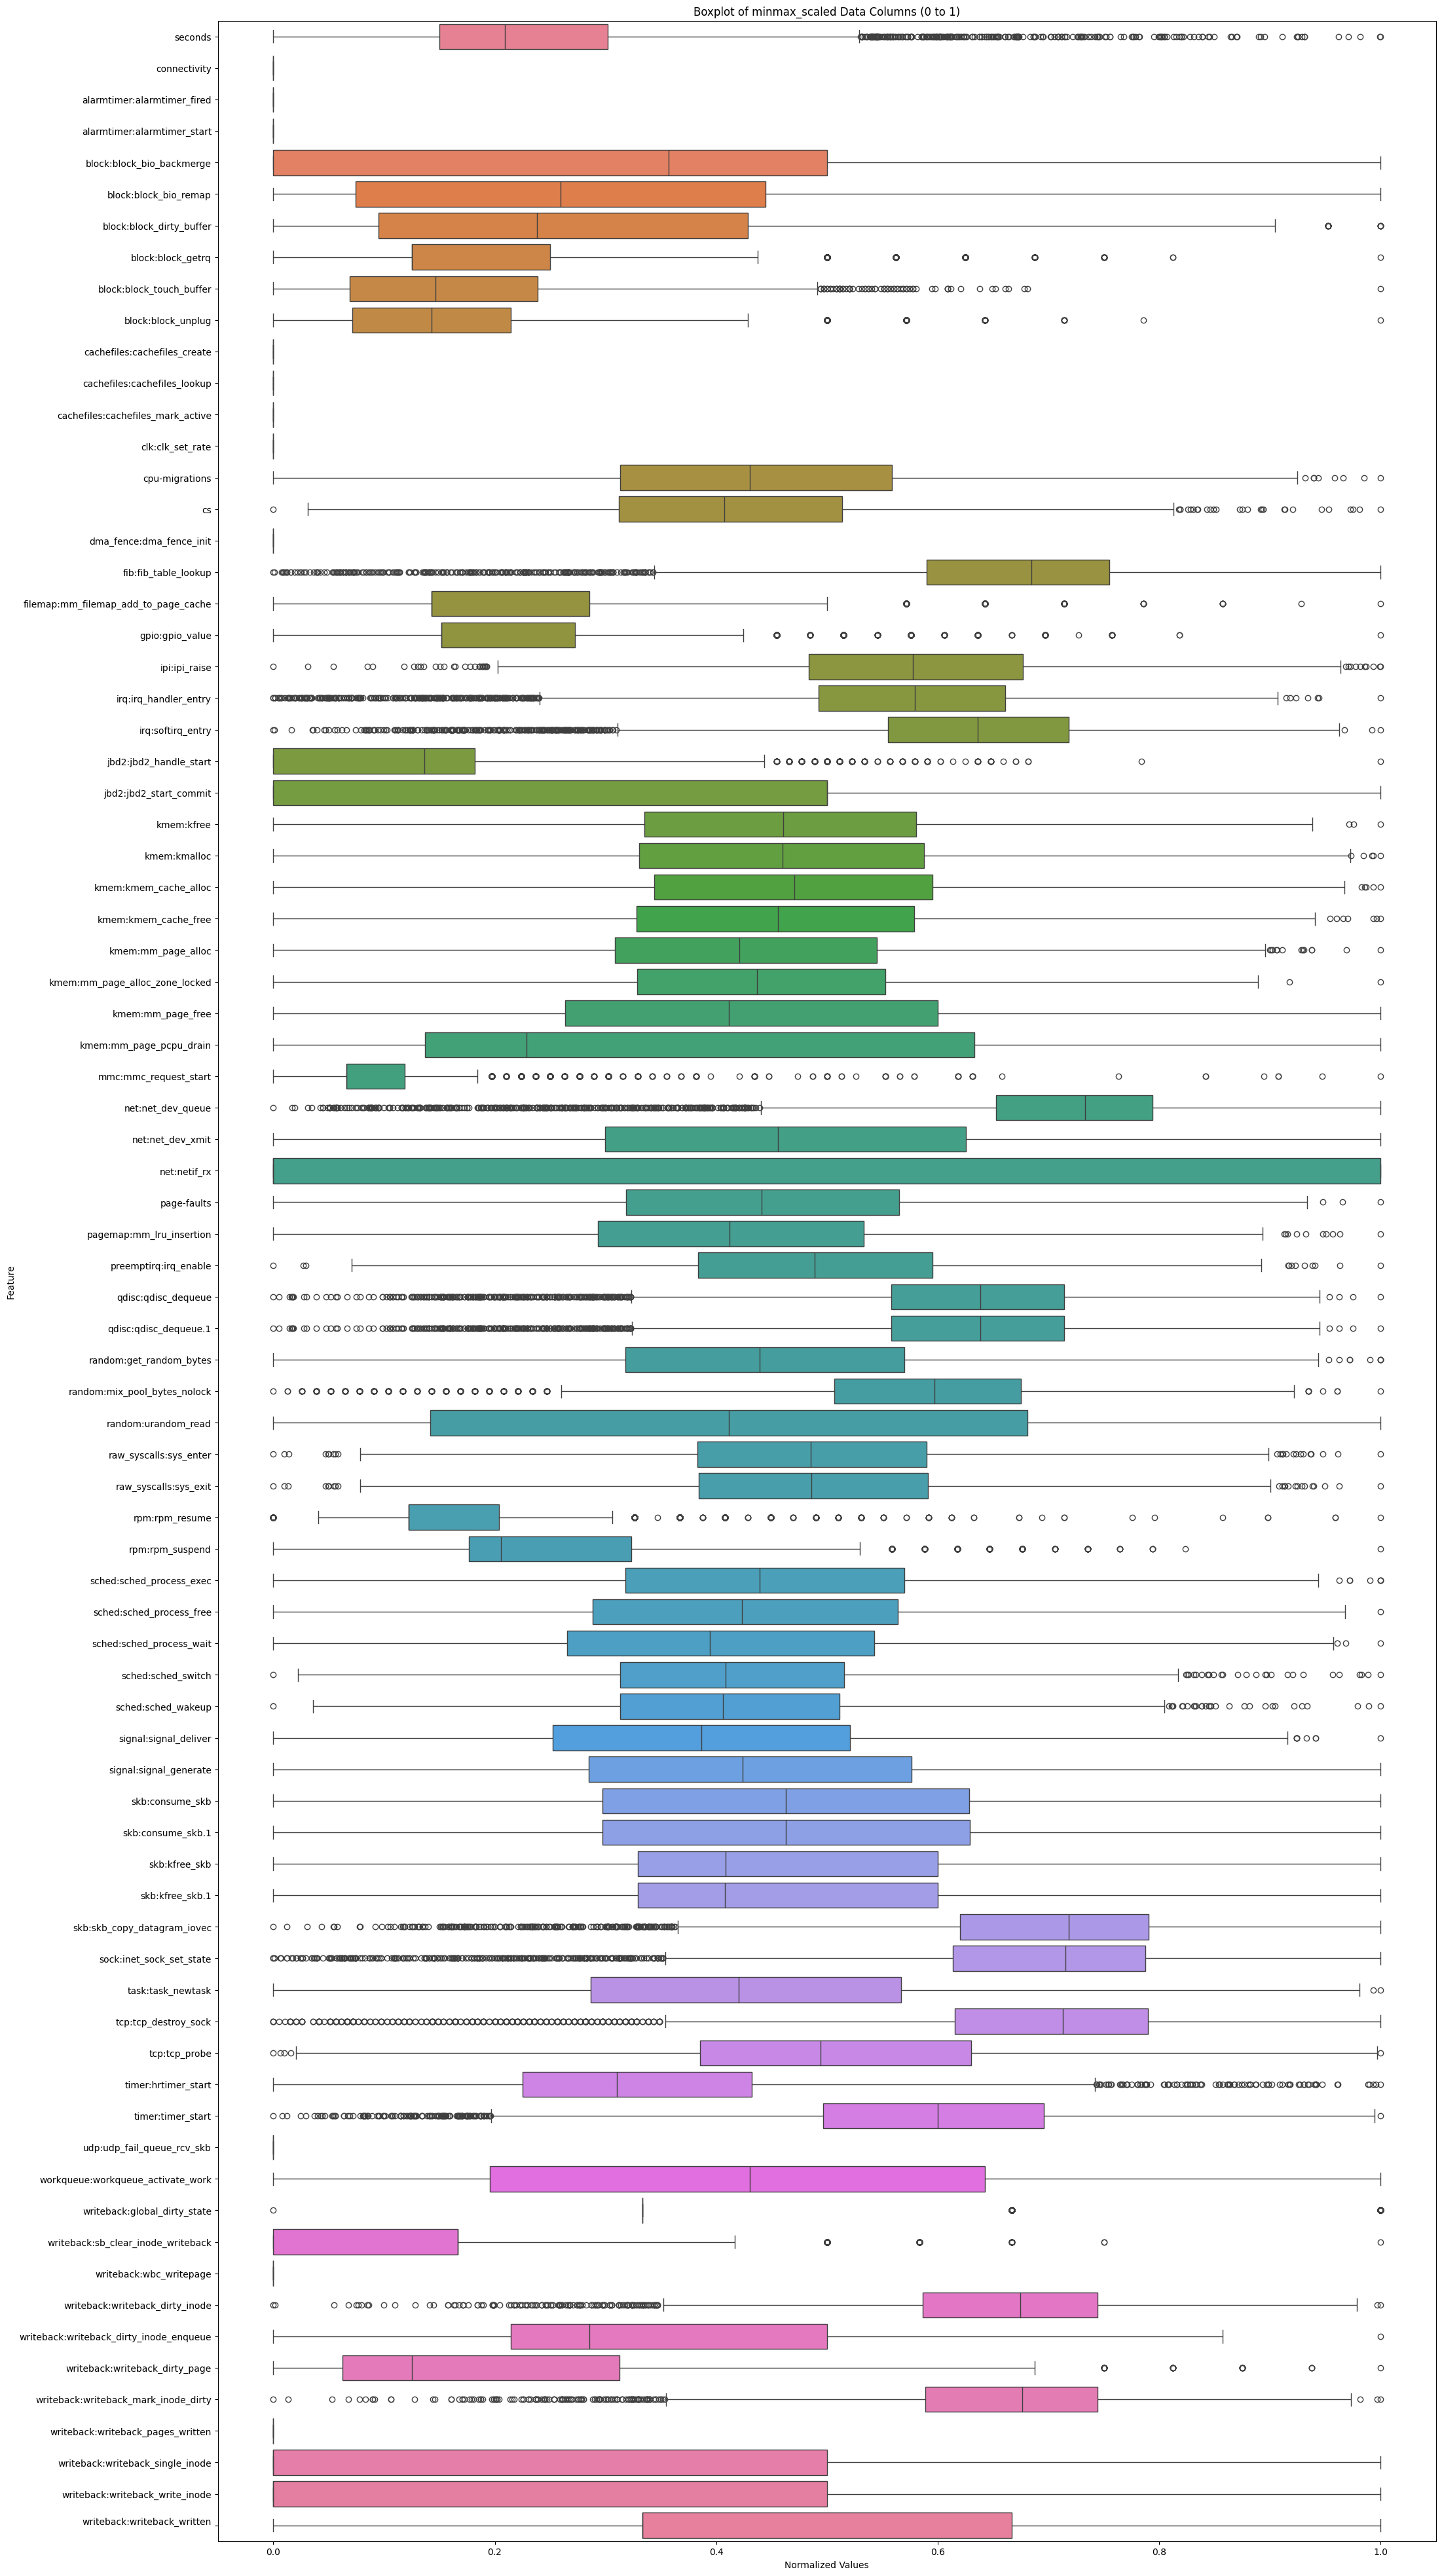

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 50))
sns.boxplot(data=vectors_robust_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

In [13]:
len(vectors_scaled.columns)

81

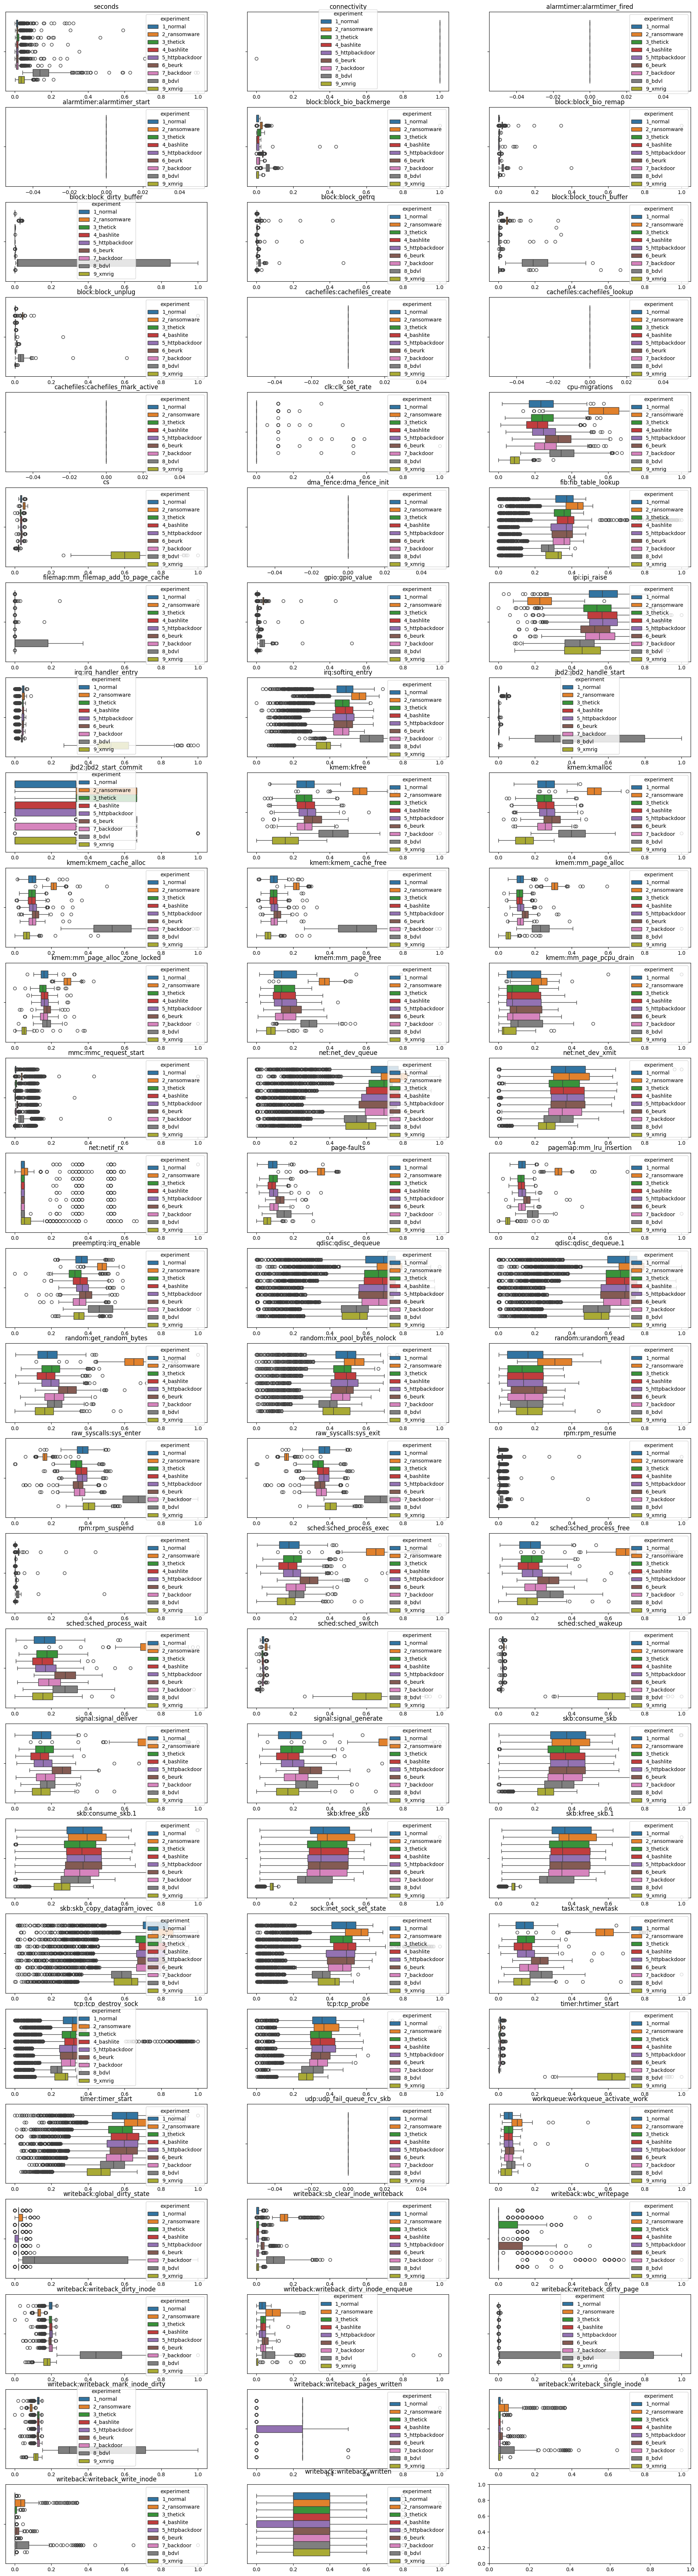

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

fig, axs = plt.subplots(27, 3, figsize=(24, 90))

# Flatten the axes for easier indexing
axs = axs.flatten()

# labels = vectors_scaled["experiment"].unique()
# handles, labels = axs[0].get_legend_handles_labels()

# Plot each column as a boxplot
for i, column in enumerate(vectors_scaled.columns):
    if column == "experiment":
        continue

    sns.boxplot(data=vectors_scaled, x=column, ax=axs[i], hue="experiment", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

# axs[1].legend(['Survived', 'Not Survived'])

# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.xlabel('Values')
# plt.legend(loc='upper right')
# plt.tight_layout()
# labels = vectors_scaled["experiment"].unique()
# # handles, labels = axs[0].get_legend_handles_labels()
# plt.legend(labels, loc='upper right')
plt.show()

#### Make a narrow dataset

In [16]:
vectors_scaled.head(1)

seconds  connectivity  alarmtimer:alarmtimer_fired  \
0  0.007193           1.0                          0.0   

   alarmtimer:alarmtimer_start  block:block_bio_backmerge  \
0                          0.0                   0.017442   

   block:block_bio_remap  block:block_dirty_buffer  block:block_getrq  \
0               0.004367                  0.001594           0.001357   

   block:block_touch_buffer  block:block_unplug  ...  writeback:wbc_writepage  \
0                  0.012696            0.001761  ...                      0.0   

   writeback:writeback_dirty_inode  writeback:writeback_dirty_inode_enqueue  \
0                         0.136056                                 0.057554   

   writeback:writeback_dirty_page  writeback:writeback_mark_inode_dirty  \
0                         0.00161                              0.089577   

   writeback:writeback_pages_written  writeback:writeback_single_inode  \
0                               0.25                               0.0   

   writeback:writeback_write_inode  writeback:writeback_written\n  experiment  
0                              0.0                            0.2    1_normal  

[1 rows x 81 columns]

In [17]:
narrow_df = pd.melt(vectors_scaled, id_vars=['experiment'], var_name='x', value_name='y')
narrow_df.head(1)

experiment        x         y
0   1_normal  seconds  0.007193

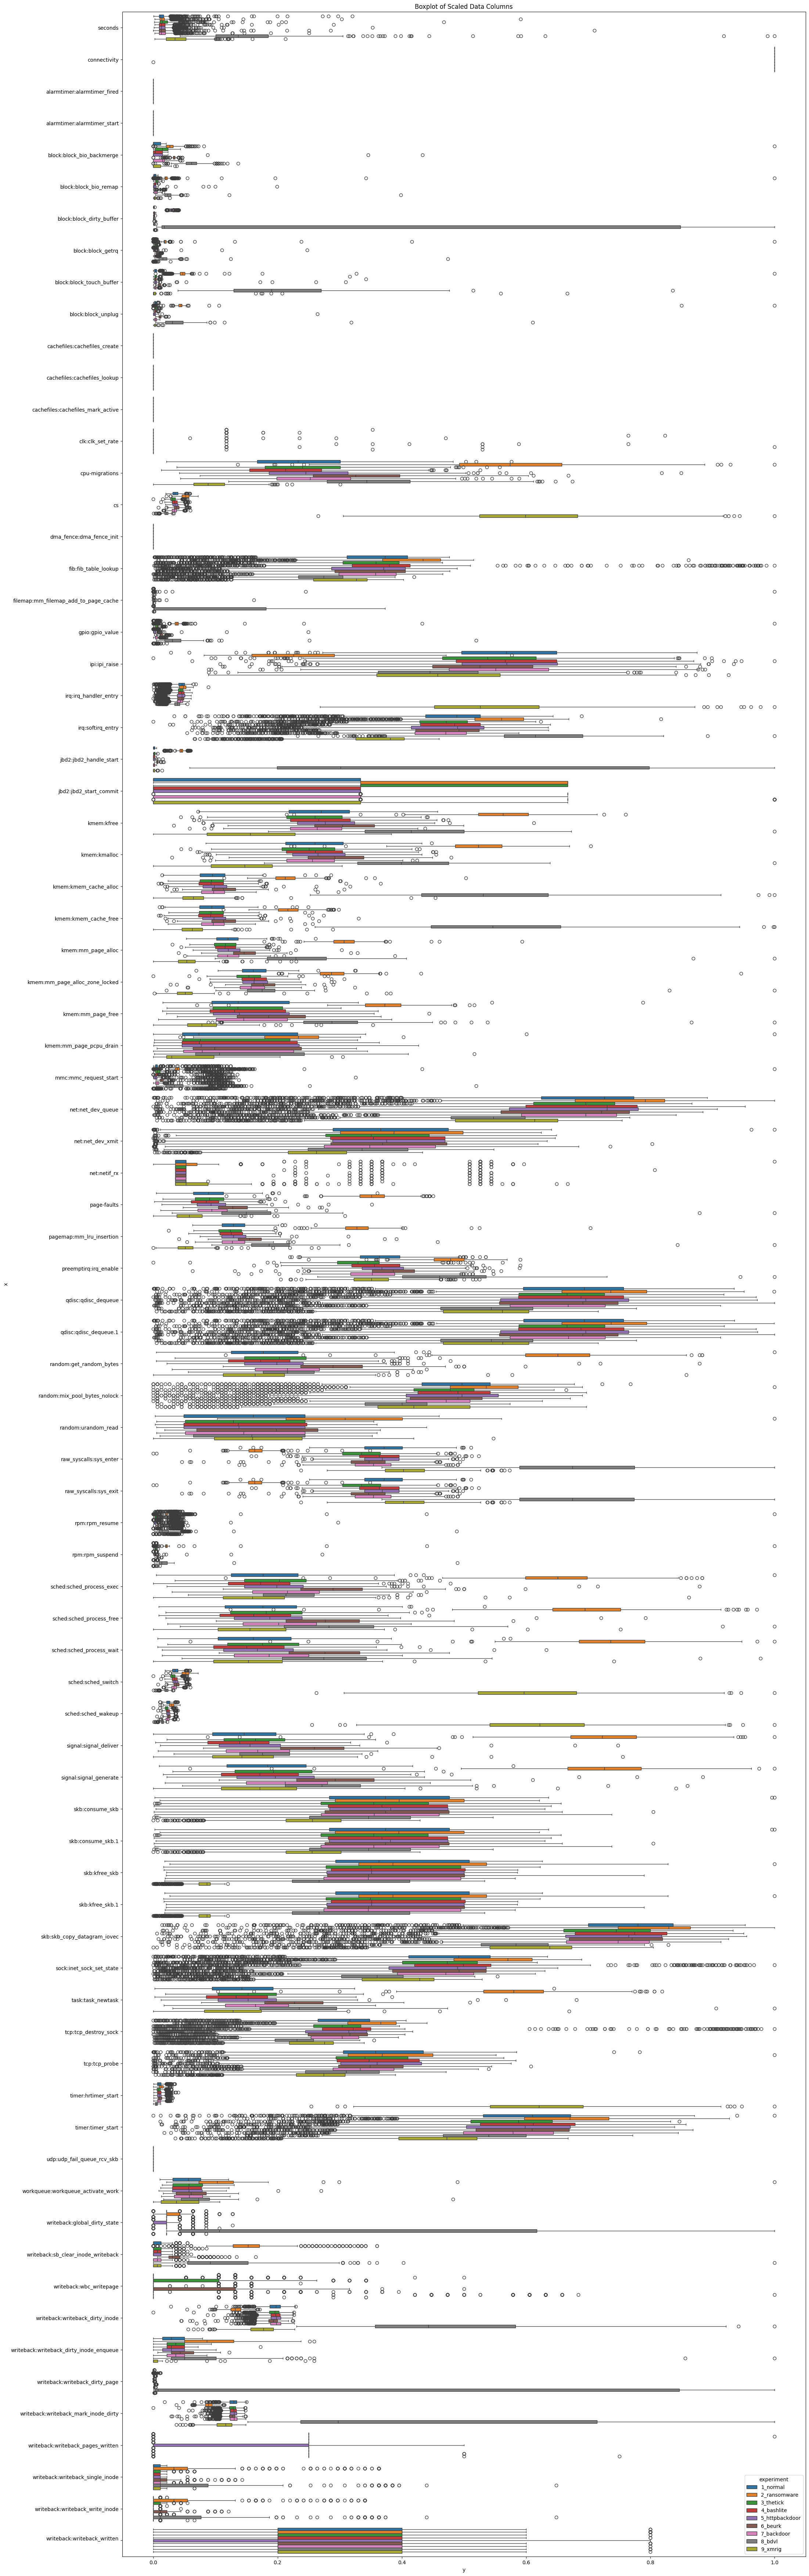

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 90))
# sns.boxplot(data=narrow_df, x="x", y="y"
# hue = "experiment")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",
            hue="experiment")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

In [22]:
assert False, "Stop here, doesnt make sense anyway"

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 90))
# sns.boxplot(data=narrow_df, x="experiment", y="y",  #orient="h",
#             hue="x")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",
            hue="experiment")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

AssertionError: Stop here, doesnt make sense anyway